In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim

In [2]:
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

In [4]:
NUM_DIGITS = 10
NUM_SAMPLES = 1024

### Create some data

In [5]:
def binary_encode(i, num_digits):
    """returns values in MSB 0 bit numbering order, i.e the right most bit is the most significant"""
    return np.array([i >> d & 1 for d in range(num_digits)])

In [6]:
x = np.array([binary_encode(x, NUM_DIGITS) for x in range(1,NUM_SAMPLES)])
x

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 1, ..., 1, 1, 1],
       [0, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In [7]:
# understand the binary creation logic
i=15
for d in range(NUM_DIGITS):
    print(d, i >> d, i >> d & 1)

0 15 1
1 7 1
2 3 1
3 1 1
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0


In [8]:
x[14]

array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0])

In [9]:
def fizz_buzz_encode(i):
    if   i % 15 == 0: return np.array([0, 0, 0, 1])
    elif i % 5  == 0: return np.array([0, 0, 1, 0])
    elif i % 3  == 0: return np.array([0, 1, 0, 0])
    else:             return np.array([1, 0, 0, 0])

In [10]:
def fizz_buzz_text(i):
    if   i % 15 == 0: return 'Fizzbuzz'
    elif i % 5  == 0: return 'buzz'
    elif i % 3  == 0: return 'Fizz'
    else:             return str(i)

In [11]:
# create a text based version of the encoder to verify - also an actual answer to the fizzbuzz problem.
[fizz_buzz_text(x) for x in range(1,31)]

['1',
 '2',
 'Fizz',
 '4',
 'buzz',
 'Fizz',
 '7',
 '8',
 'Fizz',
 'buzz',
 '11',
 'Fizz',
 '13',
 '14',
 'Fizzbuzz',
 '16',
 '17',
 'Fizz',
 '19',
 'buzz',
 'Fizz',
 '22',
 '23',
 'Fizz',
 'buzz',
 '26',
 'Fizz',
 '28',
 '29',
 'Fizzbuzz']

In [12]:
y = np.array([fizz_buzz_encode(x) for x in range(1,NUM_SAMPLES)])
y

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       ...,
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0]])

In [13]:
# convert to tensors
t_x = torch.tensor(x,dtype=torch.float).unsqueeze(1)
t_y = torch.tensor(y).unsqueeze(1)

In [14]:
print(t_y.dtype)
t_y.shape

torch.int64


torch.Size([1023, 1, 4])

In [15]:
print(t_x.dtype)
t_x.shape

torch.float32


torch.Size([1023, 1, 10])

In [16]:
#create a simple model using the sequential module
model = nn.Sequential(nn.Linear(10,100),
                     nn.ReLU(),
                      nn.Linear(100,100),
                     nn.ReLU(),
                      nn.Linear(100,4)
                     )

In [17]:
model

Sequential(
  (0): Linear(in_features=10, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=4, bias=True)
)

In [18]:
# check the model can process the data
pred = model(t_x)
pred.shape

torch.Size([1023, 1, 4])

In [19]:
pred

tensor([[[ 0.0378, -0.0352,  0.0335,  0.0613]],

        [[ 0.0640, -0.0051,  0.0261,  0.1120]],

        [[ 0.0545, -0.0068,  0.0235,  0.0911]],

        ...,

        [[ 0.0195, -0.0409,  0.0184,  0.1112]],

        [[ 0.0317, -0.0457, -0.0159,  0.1291]],

        [[ 0.0340, -0.0526,  0.0214,  0.1193]]], grad_fn=<AddBackward0>)

In [20]:
#check the loss function will function with the tensors
loss_BCELL = nn.BCEWithLogitsLoss()
loss_BCELL(pred,t_y.float())

tensor(0.7045, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

### An aside on multiclass output - to check my understanding
https://stackoverflow.com/questions/52855843/multi-label-classification-in-pytorch

In [21]:
#create some random data
test_batch=2
test_classes = 5
outputs_before_sigmoid = torch.randn(test_batch, test_classes)
outputs_before_sigmoid

tensor([[ 1.0608, -1.7887,  2.0753, -0.0960,  1.4551],
        [ 1.0870, -0.7898,  0.2738, -0.5451,  0.8420]])

In [22]:
# create one hot encoded target values
target_classes = torch.tensor([[0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0]])
target_classes

tensor([[0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0]])

In [23]:
# look at those inputs after a sigmoid
# the inputs have been transformed to a 0-1 space
sigmoid_outputs = torch.sigmoid(outputs_before_sigmoid)
sigmoid_outputs

tensor([[0.7428, 0.1432, 0.8885, 0.4760, 0.8108],
        [0.7478, 0.3122, 0.5680, 0.3670, 0.6989]])

In [24]:
# look at the inputs after a softmax
# the sum across each row is now 1
softmax_outputs = torch.softmax(outputs_before_sigmoid,dim=1)
softmax_outputs

tensor([[0.1781, 0.0103, 0.4913, 0.0560, 0.2642],
        [0.3884, 0.0595, 0.1722, 0.0759, 0.3040]])

In [25]:
# BCE Loss needs sigmoid inputs
loss_BCE= nn.BCELoss()
loss_BCE(sigmoid_outputs,target_classes.float())

tensor(1.0968)

In [26]:
# BCELogitsLoss can deal with inputs before sigmoid transformation - it does this itself internally
loss_BCELL=nn.BCEWithLogitsLoss()
loss_BCELL(outputs_before_sigmoid,target_classes.float())

tensor(1.0968)

In [27]:
# the loss of a perfect answer is zero!
loss_BCE(target_classes.float(),target_classes.float())

tensor(0.)

In [28]:
# for comparison a mutliclass input
target_multi_classs = torch.tensor([1,2])
target_multi_classs

tensor([1, 2])

In [29]:
# using the Cross entropy loss function for multiclass
loss_CE = nn.CrossEntropyLoss()
loss_CE(softmax_outputs, target_multi_classs)

tensor(1.7299)

### aside over, create a train-validation split

In [30]:
# shufffle the indices
shuffled_indices = torch.randperm(t_x.shape[0])

In [31]:
train_valid_split_percentage = 0.9

In [32]:
tv_split = int(train_valid_split_percentage * t_x.shape[0])
tv_split

920

In [33]:
# split using the cut off above into train and validation sets
valid_x = t_x[shuffled_indices[tv_split:]]
valid_y = t_y[shuffled_indices[tv_split:]]

train_x = t_x[shuffled_indices[:tv_split]]
train_y = t_y[shuffled_indices[:tv_split]]



In [34]:
print(train_x.shape[0], valid_x.shape[0])

920 103


In [35]:
# using a pytorch optimiser
optimiser = optim.SGD(model.parameters(), lr=1e-1)

### Training Loop

In [36]:
# function to perform training
def training_loop(epochs, optimiser, model, loss_fn, x,y, vx, vy, batch_size):
    model.cuda()  # move model to GPU
    val_losses=[]
    train_losses=[]
    
    for epoch in range(1, epochs+1):
        #shuffle the inputs each epoch
        shuffled_indexes = torch.randperm(x.shape[0])
       
        #run in batches (not really needed for a data set this size but general good practice)
        for bs in range(0,x.shape[0],batch_size):
            
            batch_indices= shuffled_indexes[bs:bs+batch_size] # select a batch size number of shuffled indices
            batch = x[batch_indices].cuda() # select a batch of samples and move to the GPU
            target = y[batch_indices].cuda()

            # perform the forward and back passes through the network
            pred = model(batch)
            loss_train = loss_fn(pred,target.float())

            optimiser.zero_grad()
            loss_train.backward()
            optimiser.step()

        if epoch == 1 or epoch % 1000 ==0:
            loss_float = float(loss_train)
            
            # not necessary for a model this size but good practice to prevent gradient accumulation of
            # validation set
            with torch.no_grad():
                v_pred = model(vx.cuda())
                loss_valid = float(loss_fn(v_pred, vy.cuda().float()))
            
            
            print(f'Epoch: {epoch} Training Loss: {loss_float} Valid Loss: {loss_valid}')

            val_losses.append(loss_valid)
            train_losses.append(loss_train)
            
    return train_losses, val_losses

        

In [37]:
%%time
tl, vl = training_loop(10000,optimiser,model,loss_BCELL,train_x,train_y,valid_x, valid_y,256)

Epoch: 1 Training Loss: 0.6804282665252686 Valid Loss: 0.6800763607025146
Epoch: 1000 Training Loss: 0.46165356040000916 Valid Loss: 0.5527530312538147
Epoch: 2000 Training Loss: 0.3105538487434387 Valid Loss: 0.4712944030761719
Epoch: 3000 Training Loss: 0.0597224123775959 Valid Loss: 0.1754443198442459
Epoch: 4000 Training Loss: 0.02021985501050949 Valid Loss: 0.10381665080785751
Epoch: 5000 Training Loss: 0.009041178040206432 Valid Loss: 0.09339012950658798
Epoch: 6000 Training Loss: 0.004883074667304754 Valid Loss: 0.09653986245393753
Epoch: 7000 Training Loss: 0.0034646173007786274 Valid Loss: 0.09137961268424988
Epoch: 8000 Training Loss: 0.002309216419234872 Valid Loss: 0.09255336970090866
Epoch: 9000 Training Loss: 0.0017121293349191546 Valid Loss: 0.09014353901147842
Epoch: 10000 Training Loss: 0.0013916457537561655 Valid Loss: 0.09119658917188644
CPU times: user 42.6 s, sys: 1.44 s, total: 44.1 s
Wall time: 43.6 s


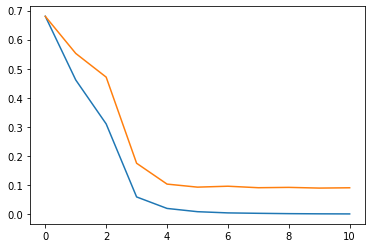

In [38]:
plt.plot(tl)
plt.plot(vl)

### Review Results

In [39]:
test_id=14
t_x[test_id]

tensor([[1., 1., 1., 1., 0., 0., 0., 0., 0., 0.]])

In [40]:
t_y[test_id]

tensor([[0, 0, 0, 1]])

In [41]:
torch.sigmoid(model(t_x[test_id].cuda()))

tensor([[3.2803e-07, 4.3853e-03, 6.5699e-03, 9.9675e-01]], device='cuda:0',
       grad_fn=<SigmoidBackward>)

In [42]:
torch.argmax(torch.sigmoid(model(t_x[test_id].cuda())))

tensor(3, device='cuda:0')

Works for single result - now for all results

In [43]:
# get the raw predictions
raw_preds = torch.sigmoid(model(t_x.cuda())).cpu()

In [44]:
# convert to multiclass code
preds = torch.argmax(raw_preds, axis=2).numpy()

In [45]:
actuals = torch.argmax(t_y, axis=2).numpy()

In [46]:
# check raw accuracy
acc = np.sum(preds == actuals)
print(acc, acc/1024)

1016 0.9921875


In [47]:
# examine the elements that were wrong
error_indexs = np.where((preds == actuals)== False)[0]

In [48]:
error_indexs

array([ 67, 338, 470, 553, 685, 954, 984])

In [49]:
for e in error_indexs:
    print(e+1, torch.argmax(t_y[e]).item(), preds[e][0], fizz_buzz_text(e+1))

68 0 2 68
339 1 0 Fizz
471 1 0 Fizz
554 0 1 554
686 0 1 686
955 2 0 buzz
985 2 0 buzz
